## References
- Preview tables on GBQ: https://console.cloud.google.com/bigquery?project=chembl-kf&folder&organizationId&p=patents-public-data&d=ebi_chembl&page=dataset
- Schema - text: http://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_23/schema_documentation.html
- Schema - visual: http://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_23/chembl_23_schema.png

In [1]:
from google.cloud import bigquery # Import the Google Cloud client library
import bq_helper # Import bq_helper module

import pandas as pd
import numpy as np

import util as u
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

In [8]:
# Instantiate a client implicitly -- looks for credentials in an environmental variable
client = bigquery.Client()

# instantiate a BigQueryHelper object
ebi_chembl = bq_helper.BigQueryHelper(active_project="patents-public-data", dataset_name="ebi_chembl")

In [9]:
client

### Compound Properties

- phy-chem data from compount_properties
- max phase, withdrawn_flag from molecule_dictionary
- patent info from product_patents
- small molecule compounds only

In [77]:
q5b = """
SELECT md.molregno as molecule_key, md.pref_name as molecule_name, 
    mw_freebase, alogp, acd_logp, acd_logd, hba, hbd, psa, rtb, ro3_pass, num_ro5_violations, 
    ACD_MOST_APKA, ACD_MOST_BPKA, MOLECULAR_SPECIES, AROMATIC_RINGS, HEAVY_ATOMS, QED_WEIGHTED, 
    HBA_LIPINSKI, HBD_LIPINSKI, NUM_LIPINSKI_RO5_VIOLATIONS,
     md.max_phase as phase, CAST(md.withdrawn_flag AS INT64) as withdrawn, num_patents
FROM `patents-public-data.ebi_chembl.molecule_dictionary_24` AS md
JOIN `patents-public-data.ebi_chembl.compound_properties_24` AS cp ON cp.molregno = md.molregno
LEFT JOIN (
    SELECT form.molregno, COUNT(DISTINCT(pp.patent_no)) as num_patents
    FROM `patents-public-data.ebi_chembl.formulations_24` AS form
    JOIN `patents-public-data.ebi_chembl.product_patents_24` AS pp ON pp.product_id = form.product_id
    GROUP BY form.molregno
    ) AS pats 
  ON md.molregno = pats.molregno
WHERE md.molecule_type = 'Small molecule'
"""
ebi_chembl.estimate_query_size(q5b)

0.20395510271191597

In [78]:
response5b = ebi_chembl.query_to_pandas_safe(q5b)
response5b.head()

,molecule_key,molecule_name,mw_freebase,alogp,acd_logp,acd_logd,hba,hbd,psa,rtb,...,MOLECULAR_SPECIES,AROMATIC_RINGS,HEAVY_ATOMS,QED_WEIGHTED,HBA_LIPINSKI,HBD_LIPINSKI,NUM_LIPINSKI_RO5_VIOLATIONS,phase,withdrawn,num_patents
0,460508,None,691.65,1.92,1.69,1.69,13,8,222.86,6,...,NEUTRAL,7,51,0.12,15,8,None,0,0,NaN
1,506107,None,934.63,1,1.7,-4.57,26,15,452,2,...,ACID,7,67,0.04,26,15,None,0,0,NaN
2,623893,None,913.88,9.13,-0.23,-5.75,18,7,372.91,11,...,ACID,7,63,0.02,22,9,None,0,0,NaN
3,460509,None,691.65,1.92,1.81,1.81,13,8,222.86,6,...,NEUTRAL,7,51,0.12,15,8,None,0,0,NaN
4,47659,None,810.68,6.12,2.12,-3.13,16,8,282.68,6,...,ACID,9,60,0.09,16,8,None,0,0,NaN


In [96]:
response5b.to_csv('Data/compound_properties_02.csv', index=False)

Note not all molecules in molecule_dictionary not contain an entry in compound_properties -- this is where some of the patent & approval attrition is coming from.

In [32]:
q5c = """
SELECT COUNT(md.molregno) as num_mols_md, COUNT(cp.molregno) as num_mols_cp 
FROM `patents-public-data.ebi_chembl.molecule_dictionary_24` AS md
LEFT JOIN `patents-public-data.ebi_chembl.compound_properties_24` AS cp 
ON cp.molregno = md.molregno
WHERE md.molecule_type = 'Small molecule'

"""
ebi_chembl.estimate_query_size(q5c)

0.05434732884168625

In [33]:
response5c = ebi_chembl.query_to_pandas_safe(q5c)
response5c

,num_mols_md,num_mols_cp
0,1701313,1699286


## Target info

In [49]:
# There could be >1 target per molecule. use ARRAY_AGG
q8b = """
SELECT md.molregno as molecule_key, ANY_VALUE(md.pref_name) as molecule_name, 
    ARRAY_AGG(STRUCT(t.pref_name as name, t.parent_type as class, t.organism as organism, 
                t.tax_id as tax_id)) AS target,
    COUNT(t.tid) as num_targets
FROM `patents-public-data.ebi_chembl.molecule_dictionary_24` as md
LEFT JOIN(
    SELECT td.pref_name, tt.parent_type, td.organism, td.tax_id,
        act.molregno, td.tid
    FROM `patents-public-data.ebi_chembl.target_dictionary_24` AS td
    JOIN `patents-public-data.ebi_chembl.target_type_24` AS tt ON td.target_type = tt.target_type
    JOIN `patents-public-data.ebi_chembl.assays_24` AS a ON a.tid = td.tid
    JOIN `patents-public-data.ebi_chembl.activities_24` AS act ON act.assay_id = a.assay_id
    ) as t
ON t.molregno = md.molregno
WHERE md.molecule_type = 'Small molecule'
GROUP BY md.molregno
        """
ebi_chembl.estimate_query_size(q8b)

0.289852699264884

In [50]:
response8b = ebi_chembl.query_to_pandas_safe(q8b)
response8b.head()

,molecule_key,molecule_name,target,num_targets
0,1006305,None,"[{'name': 'Plasmodium falciparum', 'class': 'N...",6
1,1006435,None,"[{'name': 'Cellular tumor antigen p53', 'class...",18
2,1006551,None,"[{'name': 'Chromobox protein homolog 1', 'clas...",4
3,1006602,None,"[{'name': 'Unchecked', 'class': 'UNDEFINED', '...",7
4,1006685,None,[{'name': 'Mothers against decapentaplegic hom...,18


In [73]:
len(response8b)

1701313

A wide variety in number of targets by molecule -- this will be a good numerical feature to include:

In [49]:
response8b['num_targets'].describe()

count    1.701313e+06
mean     8.693708e+00
std      4.483590e+01
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      1.557700e+04
Name: num_targets, dtype: float64

#### "Extract" target class info

In [51]:
df = response8b

In [84]:
# df['target_class'] = df['target'].apply(x['class'] for x in row)
df['classes_extracted'] = df['target'].apply(lambda struct: list(set([x['class'] for x in struct])))
df['orgs_extracted'] = df['target'].apply(lambda struct: list(set([x['organism'] for x in struct])))
df['org_ids_extracted'] = df['target'].apply(lambda struct: list(set([x['tax_id'] for x in struct])))
df['classes_extracted2'] = df['classes_extracted'].apply(lambda x: ','.join(list(filter(lambda y: y != None, x))))
df['human_target'] = df['org_ids_extracted'].apply(lambda x: 1 if '9606' in x else 0)

NameError: name 'row' is not defined

In [86]:
df.head()

,molecule_key,molecule_name,target,num_targets,classes_extracted,orgs_extracted,org_ids_extracted,classes_extracted2,human_target
0,1006305,None,"[{'name': 'Plasmodium falciparum', 'class': 'N...",6,"[UNDEFINED, NON-MOLECULAR, PROTEIN]","[None, Plasmodium falciparum, Homo sapiens]","[9606, 5833, None]","UNDEFINED,NON-MOLECULAR,PROTEIN",1
1,1006435,None,"[{'name': 'Cellular tumor antigen p53', 'class...",18,"[UNDEFINED, MOLECULAR, PROTEIN]","[Photinus pyralis, None, Homo sapiens]","[9606, None, 7054]","UNDEFINED,MOLECULAR,PROTEIN",1
2,1006551,None,"[{'name': 'Chromobox protein homolog 1', 'clas...",4,[PROTEIN],"[Human immunodeficiency virus 1, Homo sapiens]","[9606, 11676]",PROTEIN,1
3,1006602,None,"[{'name': 'Unchecked', 'class': 'UNDEFINED', '...",7,"[UNDEFINED, NON-MOLECULAR, PROTEIN]","[Homo sapiens, Plasmodium falciparum, None]","[9606, 5833, None]","UNDEFINED,NON-MOLECULAR,PROTEIN",1
4,1006685,None,[{'name': 'Mothers against decapentaplegic hom...,18,"[UNDEFINED, NON-MOLECULAR, PROTEIN]","[Mus musculus, Plasmodium falciparum, Bacillus...","[10090, 9606, None, 1423, 5833, 10116]","UNDEFINED,NON-MOLECULAR,PROTEIN",1


Performed the following after the dataframe had been saved. Note: When saving as a .csv, the lists become one large string, so "extracting" becomes a Regex manipulation. Would have been better to pickle the dataframe.

In [3]:
# df.to_csv('Data/molecule_target_agg_query.csv')
df = pd.read_csv('Data/molecule_target_agg_query.csv')
# u.pkl_this('Data/molecule_target_agg_query.pkl', df)
# df = u.open_pkl('Data/molecule_target_agg_query.pkl')

In [11]:
df['num_target_organisms'] = df['org_ids_extracted'].apply(lambda x: len(x.split(',')))

In [12]:
df.head()

,Unnamed: 0,molecule_key,molecule_name,target,num_targets,org_ids_extracted,classes_extracted2,human_target,num_target_organisms
0,0,1006305,NaN,"[{'name': 'Plasmodium falciparum', 'class': 'N...",6,"['9606', '5833', None]","UNDEFINED,NON-MOLECULAR,PROTEIN",1,3
1,1,1006435,NaN,"[{'name': 'Cellular tumor antigen p53', 'class...",18,"['9606', None, '7054']","UNDEFINED,MOLECULAR,PROTEIN",1,3
2,2,1006551,NaN,"[{'name': 'Chromobox protein homolog 1', 'clas...",4,"['9606', '11676']",PROTEIN,1,2
3,3,1006602,NaN,"[{'name': 'Unchecked', 'class': 'UNDEFINED', '...",7,"['9606', '5833', None]","UNDEFINED,NON-MOLECULAR,PROTEIN",1,3
4,4,1006685,NaN,[{'name': 'Mothers against decapentaplegic hom...,18,"['10090', '9606', None, '1423', '5833', '10116']","UNDEFINED,NON-MOLECULAR,PROTEIN",1,6


In [17]:
df.to_csv('Data/molecule_target_agg_query.csv', index=False)
# df = pd.read_csv('Data/molecule_target_agg_query.csv')

u.pkl_this('Data/molecule_target_agg_query.pkl', df)
# df = u.open_pkl('Data/molecule_target_agg_query.pkl')

Run query again, include target_id

In [109]:
# run this again, include target_id
q8f = """
SELECT md.molregno as molecule_key, ANY_VALUE(md.pref_name) as molecule_name, 
    ARRAY_AGG(STRUCT(t.tid)) as target_ids,
    COUNT(t.tid) as num_targets
FROM `patents-public-data.ebi_chembl.molecule_dictionary_24` as md
LEFT JOIN(
    SELECT act.molregno, td.tid
    FROM `patents-public-data.ebi_chembl.target_dictionary_24` AS td
    JOIN `patents-public-data.ebi_chembl.target_type_24` AS tt ON td.target_type = tt.target_type
    JOIN `patents-public-data.ebi_chembl.assays_24` AS a ON a.tid = td.tid
    JOIN `patents-public-data.ebi_chembl.activities_24` AS act ON act.assay_id = a.assay_id
    ) as t
ON t.molregno = md.molregno
WHERE md.molecule_type = 'Small molecule'
GROUP BY md.molregno
        """
ebi_chembl.estimate_query_size(q8f)


0.28927554097026587

In [110]:
response8f = ebi_chembl.query_to_pandas_safe(q8f)

In [111]:
response8f.head()

,molecule_key,molecule_name,target_ids,num_targets
0,300022,CARBOPLATIN,"[{'tid': '22226'}, {'tid': '22226'}, {'tid': '...",2516
1,193323,Platinum complex II,"[{'tid': '80156'}, {'tid': '80697'}, {'tid': '...",25
2,1286173,None,"[{'tid': '81123'}, {'tid': '81322'}, {'tid': '...",57
3,1291449,None,"[{'tid': '80354'}, {'tid': '80560'}, {'tid': '...",44
4,1292975,None,"[{'tid': '80186'}, {'tid': '80575'}, {'tid': '...",57


In [112]:
df2 = response8f
df2['target_ids_extracted'] = df2['target_ids'].apply(lambda struct: list(set([x['tid'] for x in struct])))
df3 = pd.merge(df, df2[['molecule_key', 'target_ids_extracted']], on='molecule_key')

In [124]:
df3.head()

,molecule_key,molecule_name,target,num_targets,classes_extracted,orgs_extracted,org_ids_extracted,target_ids_extracted
0,674297,GADODIAMIDE,"[{'name': 'Hepatotoxicity', 'class': 'NON-MOLE...",14,[NON-MOLECULAR],[None],[None],[103956]
1,1381264,CARBOMER 1342,"[{'name': None, 'class': None, 'organism': Non...",0,[None],[None],[None],[None]
2,1592377,ETIRINOTECAN PEGOL TETRAHYDROCHLORIDE,"[{'name': None, 'class': None, 'organism': Non...",0,[None],[None],[None],[None]
3,1926850,MK-8353,"[{'name': None, 'class': None, 'organism': Non...",0,[None],[None],[None],[None]
4,1927022,IRX4310,"[{'name': None, 'class': None, 'organism': Non...",0,[None],[None],[None],[None]


In [51]:
# if run again, pickle instead!

# df3.to_csv('Data/molecule_target_agg_query.csv')
df3 = pd.read_csv('Data/molecule_target_agg_query.csv', index=False)

# for export into model:
df4 = df3.drop(columns=['Unnamed: 0', 'classes_extracted', 'orgs_extracted'])
df4.to_csv('Data/molecule_target_agg_query.csv')

### Now the reverse:
How many molecules per target? (This was an example of me wasting time on a feature I didn't end up using.)

In [10]:
q9 = """
SELECT td.tid, ANY_VALUE(td.pref_name) as target_name, ANY_VALUE(td.target_type) as target_type, 
    ANY_VALUE(tt.parent_type) as target_class, ANY_VALUE(td.organism) as target_organsim, 
    ARRAY_AGG(DISTINCT md.molregno) as molecule_key, 
    COUNT(md.molregno) as num_molecules
FROM `patents-public-data.ebi_chembl.target_dictionary_24` AS td
JOIN `patents-public-data.ebi_chembl.target_type_24` AS tt ON td.target_type = tt.target_type
JOIN `patents-public-data.ebi_chembl.assays_24` AS a ON a.tid = td.tid
JOIN `patents-public-data.ebi_chembl.activities_24` AS act ON act.assay_id = a.assay_id
JOIN `patents-public-data.ebi_chembl.molecule_dictionary_24` as md on act.molregno = md.molregno
WHERE md.molecule_type = 'Small molecule'
GROUP BY td.tid;
        """
ebi_chembl.estimate_query_size(q9)

0.28901479206979275

In [11]:
response9 = ebi_chembl.query_to_pandas_safe(q9)

In [12]:
response9.head()

,tid,target_name,target_type,target_class,target_organsim,molecule_key,num_molecules
0,100268,Ac2-L-Lys-D-Ala-D-Ala peptide,UNKNOWN,UNDEFINED,None,"[1704101, 1704098, 130741, 129976, 1704099]",5
1,107942,TPR/MET fusion protein,CHIMERIC PROTEIN,PROTEIN,Mus musculus,"[2083632, 2083644, 2083625, 2083642, 2083628, ...",51
2,104904,GABA-A receptor; benzodiazepine site,PROTEIN COMPLEX GROUP,PROTEIN,Homo sapiens,[335730],3
3,100258,AF2 neuropeptide receptor,UNKNOWN,UNDEFINED,None,"[72907, 73345, 73068, 72968, 73820, 72734, 738...",54
4,103779,Phospholipidosis,PHENOTYPE,NON-MOLECULAR,None,"[86466, 130637, 371615, 675211, 230999, 8193, ...",928


In [13]:
# response9.to_csv('Data/targets_num_molecules.csv')
u.pkl_this('Data/targets_num_molecules.pkl', response9)

In [14]:
response9['num_molecules'].value_counts()[:10]

1     901
2     600
3     419
4     362
5     246
6     245
8     201
7     179
10    172
12    161
Name: num_molecules, dtype: int64

In [18]:
for x in ['target_name', 'target_type', 'target_class', 'target_organsim']:
    print(f'{x}: {len(response9[x].unique())}')

target_name: 9134
target_type: 20
target_class: 5
target_organsim: 2427


## Assays

How many assays per molecule?

In [5]:
q10b = """
SELECT md.molregno as molecule_key, 
    ANY_VALUE(md.pref_name) as molecule_name, 
    COUNT(a.activity_id) as num_activities,
    COUNT(DISTINCT a.assay_id) as num_assays,
    ARRAY_AGG(STRUCT(a.assay_type)) as assay_types
FROM `patents-public-data.ebi_chembl.molecule_dictionary_24` as md
LEFT JOIN(
    SELECT act.molregno, act.activity_id, asy.assay_id, asy.assay_type
    FROM `patents-public-data.ebi_chembl.activities_24` AS act 
    JOIN `patents-public-data.ebi_chembl.assays_24` asy ON act.assay_id = asy.assay_id
    ) as a
ON a.molregno = md.molregno
WHERE md.molecule_type = 'Small molecule'
GROUP BY md.molregno
        """
ebi_chembl.estimate_query_size(q10b)

0.41718792356550694

In [ ]:
act2 = ebi_chembl.query_to_pandas_safe(q10b)

In [10]:
act2.head()

,molecule_key,molecule_name,num_activities,num_assays,assay_types
0,879433,None,38,38,"[{'assay_type': 'F'}, {'assay_type': 'F'}, {'a..."
1,1091202,None,104,104,"[{'assay_type': 'F'}, {'assay_type': 'F'}, {'a..."
2,828936,None,21,21,"[{'assay_type': 'F'}, {'assay_type': 'F'}, {'a..."
3,765698,None,23,23,"[{'assay_type': 'F'}, {'assay_type': 'F'}, {'a..."
4,1683361,None,23,23,"[{'assay_type': 'F'}, {'assay_type': 'F'}, {'a..."


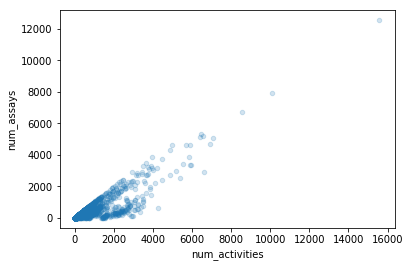

In [130]:
act2.plot(x='num_activities', y='num_assays', kind='scatter', alpha=0.2)

In [135]:
act2.num_activities.describe()

count    1.701313e+06
mean     8.693708e+00
std      4.483590e+01
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      1.557700e+04
Name: num_activities, dtype: float64

Most molecules have very few activities

In [11]:
act2['assay_types_extracted'] = act2['assay_types'].apply(lambda struct: list(set([x['assay_type'] for x in struct])))

In [12]:
act2.head()

,molecule_key,molecule_name,num_activities,num_assays,assay_types,assay_types_extracted
0,879433,None,38,38,"[{'assay_type': 'F'}, {'assay_type': 'F'}, {'a...","[B, F]"
1,1091202,None,104,104,"[{'assay_type': 'F'}, {'assay_type': 'F'}, {'a...","[B, F]"
2,828936,None,21,21,"[{'assay_type': 'F'}, {'assay_type': 'F'}, {'a...",[F]
3,765698,None,23,23,"[{'assay_type': 'F'}, {'assay_type': 'F'}, {'a...","[B, F]"
4,1683361,None,23,23,"[{'assay_type': 'F'}, {'assay_type': 'F'}, {'a...","[B, F]"


In [46]:
# act2['molecule_key']
act_df = u.to_num('molecule_key', act2)

# u.pkl_this('Data/molecule_assays.pkl', act_df.drop(columns='assay_types'))
# act_df = u.open_pkl('Data/molecule_assays.pkl')

It's easier to use CountVectorizer on a string than a list. Further "extract" assay types from list.

In [13]:
def extract_assays(row):
    if row['num_assays'] > 0:
        return ','.join(row['assay_types_extracted'])
    else:
        return ''

In [14]:
act_df['assay_types'] = act_df.apply(lambda row: extract_assays(row), axis=1)

In [15]:
act_df.head()

,molecule_key,molecule_name,num_activities,num_assays,assay_types_extracted,assay_types
0,879433,None,38,38,"[B, F]","B,F"
1,1091202,None,104,104,"[B, F]","B,F"
2,828936,None,21,21,[F],F
3,765698,None,23,23,"[B, F]","B,F"
4,1683361,None,23,23,"[B, F]","B,F"


In [17]:
u.pkl_this('Data/molecule_assays.pkl', act_df.drop(columns='assay_types_extracted'))
# act_df = u.open_pkl('Data/molecule_assays.pkl')

From query run on GBQ web: 3605 unique organism ID's in assay table

### Molecule Structure Flag

In [19]:
q11 = """
SELECT md.molregno as molecule_key, 
    COUNT(a.alert_name) as num_alerts,
    ARRAY_AGG(STRUCT(a.alert_name)) as alerts,
    (CASE WHEN COUNT(a.alert_name) > 0 THEN 1 ELSE 0 END) as alert_yn
FROM `patents-public-data.ebi_chembl.molecule_dictionary_24` as md
LEFT JOIN(
    SELECT csa.molregno, sa.alert_name
    FROM `patents-public-data.ebi_chembl.compound_structural_alerts_24` AS csa 
    JOIN `patents-public-data.ebi_chembl.structural_alerts_24` sa ON csa.alert_id = sa.alert_id
    ) as a
ON a.molregno = md.molregno
WHERE md.molecule_type = 'Small molecule'
GROUP BY md.molregno
        """
ebi_chembl.estimate_query_size(q11)

0.11085928417742252

In [20]:
alerts = ebi_chembl.query_to_pandas_safe(q11)

In [21]:
alerts.head()

,molecule_key,num_alerts,alerts,alert_yn
0,641189,20,"[{'alert_name': 'R1 Reactive alkyl halides'}, ...",1
1,866774,15,"[{'alert_name': 'I4 Disulphides'}, {'alert_nam...",1
2,1152057,14,"[{'alert_name': 'R1 Reactive alkyl halides'}, ...",1
3,3897,15,"[{'alert_name': 'I6 Epoxides, Thioepoxides, Az...",1
4,4802,19,"[{'alert_name': 'R1 Reactive alkyl halides'}, ...",1


In [23]:
len(alerts), np.sum(alerts.alert_yn)

(1701313, 1212950)

In [24]:
alerts['alert_yn'].value_counts(1)

1    0.712949
0    0.287051
Name: alert_yn, dtype: float64

- Most molecule have an alert -- can use as a feature. 
- Query not shown: 1251 distinct alert codes. It would add too much complexity to include them as-is in a model.

There are several 'alert_sets' in the database -- these could overlap. Look at individual sets.

In [27]:
q11b = """
SELECT md.molregno as molecule_key, 
    COUNT(a.alert_name) as num_alerts,
    ARRAY_AGG(STRUCT(a.alert_name)) as alerts,
    (CASE WHEN COUNT(a.alert_name) > 0 THEN 1 ELSE 0 END) as alert_yn
FROM `patents-public-data.ebi_chembl.molecule_dictionary_24` as md
LEFT JOIN(
    SELECT csa.molregno, sa.alert_name
    FROM `patents-public-data.ebi_chembl.compound_structural_alerts_24` AS csa 
    JOIN `patents-public-data.ebi_chembl.structural_alerts_24` sa ON csa.alert_id = sa.alert_id
    WHERE sa.alert_set_id = '1'
    ) as a
ON a.molregno = md.molregno
WHERE md.molecule_type = 'Small molecule' 
GROUP BY md.molregno
        """
ebi_chembl.estimate_query_size(q11b)

0.11086277943104506

In [28]:
alerts2 = ebi_chembl.query_to_pandas_safe(q11b)

In [29]:
alerts2.head()

,molecule_key,num_alerts,alerts,alert_yn
0,1376196,3,"[{'alert_name': 'R5 Sulphonates'}, {'alert_nam...",1
1,1377618,3,"[{'alert_name': 'R1 Reactive alkyl halides'}, ...",1
2,1378611,3,"[{'alert_name': 'R1 Reactive alkyl halides'}, ...",1
3,2197572,3,"[{'alert_name': 'R1 Reactive alkyl halides'}, ...",1
4,10840,3,"[{'alert_name': 'R1 Reactive alkyl halides'}, ...",1


In [30]:
alerts2['alert_yn'].value_counts(1)

0    0.909869
1    0.090131
Name: alert_yn, dtype: float64

In [31]:
alerts2['num_alerts'].describe()

count    1.701313e+06
mean     9.620687e-02
std      3.163020e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.000000e+00
Name: num_alerts, dtype: float64

This set seems fairly permissive.

In [32]:
q11c = """
SELECT md.molregno as molecule_key, 
    COUNT(a.alert_name) as num_alerts,
    ARRAY_AGG(STRUCT(a.alert_name)) as alerts,
    (CASE WHEN COUNT(a.alert_name) > 0 THEN 1 ELSE 0 END) as alert_yn
FROM `patents-public-data.ebi_chembl.molecule_dictionary_24` as md
LEFT JOIN(
    SELECT csa.molregno, sa.alert_name
    FROM `patents-public-data.ebi_chembl.compound_structural_alerts_24` AS csa 
    JOIN `patents-public-data.ebi_chembl.structural_alerts_24` sa ON csa.alert_id = sa.alert_id
    WHERE sa.alert_set_id = '8'
    ) as a
ON a.molregno = md.molregno
WHERE md.molecule_type = 'Small molecule' 
GROUP BY md.molregno
        """
ebi_chembl.estimate_query_size(q11c)

0.11086277943104506

In [33]:
alerts3 = ebi_chembl.query_to_pandas_safe(q11c)

In [35]:
alerts3.head()

,molecule_key,num_alerts,alerts,alert_yn
0,83515,4,"[{'alert_name': 'alkyl esters of S or P'}, {'a...",1
1,187696,4,"[{'alert_name': 'alkyl halide'}, {'alert_name'...",1
2,430642,4,"[{'alert_name': 'terminal vinyl'}, {'alert_nam...",1
3,581858,5,"[{'alert_name': 'alkyl esters of S or P'}, {'a...",1
4,624185,4,"[{'alert_name': 'alpha halo carbonyl'}, {'aler...",1


In [34]:
alerts3['alert_yn'].value_counts(1)

0    0.627428
1    0.372572
Name: alert_yn, dtype: float64

This alert set is less permissive

In [36]:
alerts3['num_alerts'].describe()

count    1.701313e+06
mean     4.933578e-01
std      7.441468e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      7.000000e+00
Name: num_alerts, dtype: float64

In [37]:
alert_df = pd.merge(alerts2, alerts3, on='molecule_key', suffixes=('_set1', '_set8'))

alert_df['alerts_set1_extracted'] = alert_df['alerts_set1'].apply(
    lambda struct: list(set([x['alert_name'] for x in struct])))

alert_df['alerts_set8_extracted'] = alert_df['alerts_set8'].apply(
    lambda struct: list(set([x['alert_name'] for x in struct])))

alert_df.drop(columns=['alerts_set1', 'alerts_set8'], inplace=True)

In [43]:
alert_df.head()

,molecule_key,num_alerts_set1,alert_yn_set1,num_alerts_set8,alert_yn_set8,alerts_set1_extracted,alerts_set8_extracted
0,1376196,3,1,4,1,"[R5 Sulphonates, I6 Epoxides, Thioepoxides, Az...","[aziridine-like N in 3-membered ring, S/PO3 gr..."
1,1377618,3,1,2,1,"[R21 Nitroso, R1 Reactive alkyl halides, R17 a...","[mustards, alkyl halide]"
2,1378611,3,1,2,1,"[R21 Nitroso, R1 Reactive alkyl halides, R17 a...","[mustards, alkyl halide]"
3,2197572,3,1,3,1,"[R21 Nitroso, R1 Reactive alkyl halides, R17 a...","[mustards, alkyl halide, aromatic NO2]"
4,10840,3,1,2,1,"[R21 Nitroso, R1 Reactive alkyl halides, R17 a...","[mustards, alkyl halide]"


Set 1 doesn't always yield fewer alerts than Set 8. TBD which to use in model.

In [48]:
alert_df = u.to_num('molecule_key', alert_df)

u.pkl_this('Data/molecule_structure_alerts.pkl', alert_df)

## Year

In [92]:
query2 = """
SELECT md.molregno as molecule_key, COUNT(d.year) AS num_entries, 
    MIN(d.year) as first_doc, MAX(d.year) as latest_doc
FROM `patents-public-data.ebi_chembl.molecule_dictionary_24` as md
JOIN `patents-public-data.ebi_chembl.compound_records_24` as cr ON cr.molregno = md.molregno
JOIN `patents-public-data.ebi_chembl.docs_24` as d ON d.doc_id = cr.doc_id
GROUP BY md.molregno
        """
ebi_chembl.estimate_query_size(query2)

0.04779325891286135

In [93]:
years = ebi_chembl.query_to_pandas_safe(query2)

In [187]:
query2b = """
SELECT molregno as molecule_key, usan_year
FROM `patents-public-data.ebi_chembl.molecule_dictionary_24`
WHERE molecule_type = 'Small molecule'
        """
ebi_chembl.estimate_query_size(query2b)

0.04002964124083519

In [188]:
usan_years = ebi_chembl.query_to_pandas_safe(query2b)

In [193]:
years = pd.merge(years, usan_years, on='molecule_key')

In [194]:
years.head()

,molecule_key,num_entries,first_entry,latest_entry,usan_year
0,13494,179,1978.0,2017.0,1970
1,3965,282,1977.0,2017.0,2007
2,6579,927,1977.0,2017.0,None
3,261184,6,1977.0,2017.0,None
4,255477,187,1976.0,2017.0,None


In [97]:
years['num_entries'] = pd.to_numeric(years['num_entries'])
years['first_entry'] = pd.to_numeric(years['first_entry'])
years['latest_entry'] = pd.to_numeric(years['latest_entry'])

Merge 'years' df with 'phases' df

In [ ]:
phases1 = pd.read_csv('Data/phase_info_md_di.csv')

phases1.drop(columns='drug_ind_phase', inplace=True)

phase_doc_yr = pd.merge(phases1, years, on='molecule_key')
phase_doc_yr.rename(columns={'num_entries':'num_docs'}, inplace=True)
phase_doc_yr.drop(columns='drug_ind_phases_extracted', inplace=True)

In [10]:
phase_doc_yr.head()

,Unnamed: 0,molecule_key,mol_dict_phase,thera_flag,approval_year,max_drug_ind_phase,count,num_docs,first_entry,latest_entry,approval_entry_diff
0,0,675621,4,1,1942.0,4.0,1,0,NaN,NaN,NaN
1,1,675361,4,1,1989.0,3.0,1,1,2004.0,2004.0,-15.0
2,2,675404,4,1,NaN,3.0,1,0,NaN,NaN,NaN
3,3,675436,4,1,1982.0,3.0,1,0,NaN,NaN,NaN
4,4,675443,4,1,1998.0,4.0,1,0,NaN,NaN,NaN


In [2]:
phase_doc_yr.to_csv('Data/phases_with_doc_years.csv')
# phase_doc_yr = pd.read_csv('Data/phases_with_doc_years.csv')

In [3]:
len(phase_doc_yr[phase_doc_yr['num_docs'] == 0]) / len(phase_doc_yr)

0.31644562986762964

#### Can we use difference between approval year and first_doc year to estimate how far back in time we need to discard entries?

In [4]:
phase_doc_yr['approval_entry_diff'] = phase_doc_yr['approval_year'] - phase_doc_yr['first_entry']

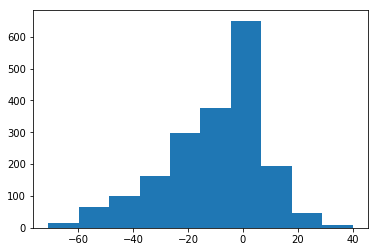

In [9]:
plt.hist(phase_doc_yr['approval_entry_diff']);

Average is 0; many differences are negative -- this will not be useful

### Investigate correlation between numbers

Not shown: 'molregno' is assigned by time of entry into db and it not indicative of "age" of molecule.

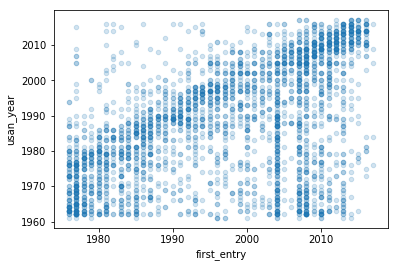

In [201]:
phase_doc_yr.plot(x='first_entry', y='usan_year', kind='scatter', alpha=0.2);

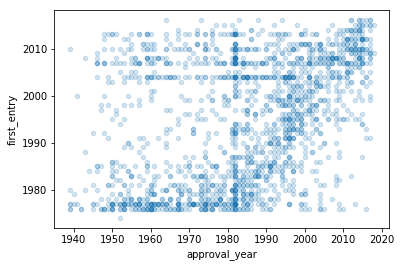

In [209]:
phase_doc_yr.plot(x='approval_year', y='first_entry', kind='scatter', alpha=0.2);

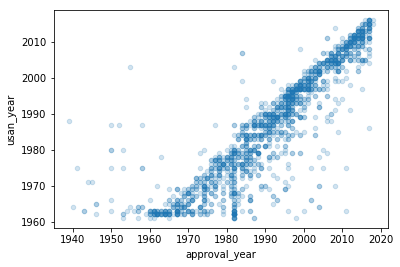

In [204]:
phase_doc_yr.plot(x='approval_year', y='usan_year', kind='scatter', alpha=0.2);

Some between the years -- esp approval_year & usan_year. Not unexepcted as would likely apply for an USAN/INN (generic) name around the time drug is approved

In [206]:
u.percent_null('approval_year', phase_doc_yr)

99.848594505756

In [207]:
u.percent_null('usan_year', phase_doc_yr)

99.66192681985582

In [208]:
u.percent_null('first_entry', phase_doc_yr)

33.843874797026636

"Impute" year for a molecule by taking the earliest of approval, first-doc, and usan years

In [132]:
def year_impute(row):
    init_guess = np.nanmin([row['approval_year'], row['first_entry'], row['usan_year']])
    return init_guess

In [133]:
phase_doc_yr['year_impute'] = phase_doc_yr.apply(lambda row: year_impute(row), axis=1)

KeyError: ('usan_year', 'occurred at index 0')

In [236]:
phase_doc_yr.sample(10)

,molecule_key,mol_dict_phase,thera_flag,approval_year,max_drug_ind_phase,count,num_docs,first_entry,latest_entry,usan_year,year_impute
1033356,702236,0,0,NaN,None,1,1,2010.0,2010.0,NaN,2010.0
377773,560864,0,0,NaN,None,1,1,2009.0,2009.0,NaN,2009.0
1106336,1683942,0,0,NaN,None,1,0,NaN,NaN,NaN,NaN
1271157,1743195,0,0,NaN,None,1,1,1979.0,1979.0,NaN,1979.0
889347,896632,0,0,NaN,None,1,0,NaN,NaN,NaN,NaN
1359955,738920,0,0,NaN,None,1,0,NaN,NaN,NaN,NaN
1032891,690560,0,0,NaN,None,1,1,2010.0,2010.0,NaN,2010.0
673555,253043,0,0,NaN,None,1,1,2001.0,2001.0,NaN,2001.0
1121141,1899415,0,0,NaN,None,1,0,NaN,NaN,NaN,NaN
1227710,1074599,0,0,NaN,None,1,1,2011.0,2011.0,NaN,2011.0


In [189]:
print(f'''If we threw out those molecules without a year,
we'd be left with {len(phase_doc_yr[phase_doc_yr['first_entry'].notnull()])} out of {len(phase_doc_yr)}''')

If we threw out those molecules without a year,
we'd be left with 1194784 out of 1747899


In [193]:
print(f'''If we further excluded those entered after 2008,
we'd be left with {len(phase_doc_yr[phase_doc_yr['first_entry'] > 2008])} out of {len(phase_doc_yr)}''')

If we further excluded those entered after 2008,
we'd be left with 669158 out of 1747899


In [195]:
print(f'''However, of these "recent" molecules, {len(phase_doc_yr[(phase_doc_yr['mol_dict_phase'] > 2) & 
                 ((phase_doc_yr['first_entry'].isnull()) & 
                  phase_doc_yr['approval_year'].isnull())])} are approved, so we could add them back in''')

However, of these "recent" molecules, 902 are approved, so we could add them back in


In [237]:
entry_year = phase_doc_yr[['molecule_key', 'num_docs', 'year_impute']]

In [238]:
entry_year.head()

,molecule_key,num_docs,year_impute
0,675621,0,1942.0
1,675604,2,1996.0
2,1763559,0,2014.0
3,1926791,1,2015.0
4,1926875,0,NaN


In [203]:
print(f' {1075742 / len(entry_year) *100: .2f}% of molecules have a year associated with them')

  66.32% of molecules have a year associated with them


In [2]:
# entry_year.to_csv('Data/entry_years.csv', index=False)
entry_year = pd.read_csv('Data/entry_years.csv')

/Users/kendra/bigquery/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kendra/bigquery/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


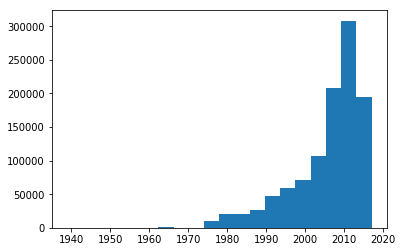

In [6]:
plt.hist(entry_year['year_impute'], bins=20);

#### Explore number of entries as a feature:

In [103]:
years['num_entries'].describe()

count    1.747899e+06
mean     8.418862e-01
std      3.539025e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.521000e+03
Name: num_entries, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1477c3940>,
 'caps': [<matplotlib.lines.Line2D at 0x1477c3fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1477c37f0>],
 'medians': [<matplotlib.lines.Line2D at 0x12be516a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x12be519e8>],
 'means': []}

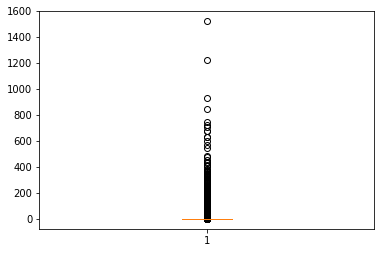

In [104]:
plt.boxplot(years['num_entries'])

Ultimately decided this is posterior information and cannot be used in model.

### Research Company

In [175]:
query5b = """
SELECT ms.molregno as molecule_key, MAX(md.max_phase) as max_phase,
    ARRAY_AGG(rc.company) as research_company,
    COUNT(rc.company) as num_companies
FROM `patents-public-data.ebi_chembl.molecule_synonyms_24` as ms
JOIN `patents-public-data.ebi_chembl.molecule_dictionary_24` as md ON md.molregno = ms.molregno
JOIN `patents-public-data.ebi_chembl.research_companies_24` as rc ON rc.res_stem_id = ms.res_stem_id
WHERE md.molecule_type = 'Small molecule' 
GROUP BY ms.molregno
        """
ebi_chembl.estimate_query_size(query5b)

0.046476264484226704

In [176]:
res_co2 = ebi_chembl.query_to_pandas_safe(query5b)

In [177]:
res_co2.head()

,molecule_key,max_phase,research_company,num_companies
0,53118,0,[GEA],1
1,1066428,0,[OSI],1
2,1078529,0,[OSI],1
3,3611,0,[Ono],1
4,33880,0,[Ono],1


In [167]:
len(res_co2)

35107

In [166]:
res_co2.num_companies.describe()

count    35107.000000
mean         1.278264
std          0.812240
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: num_companies, dtype: float64

In [178]:
res_co2.max_phase.value_counts()

0    33180
4     1118
2      386
3      280
1      143
Name: max_phase, dtype: int64

Great! this isn't a leaky variable

In [223]:
u.pkl_this('Data/molecule_research_co.pkl', res_co2)

A different approach: T/F (1/0) if molecule has an associated research co. T/F (1/0) if molecule has a synonym. (There are >150,000 entries in the synonym table, so this doesn't appear to be a leaky variable)

In [227]:
query5d = """ 
WITH mol_syn as(
    SELECT ms.molregno as key, COUNT(ms.molsyn_id) as num_syn, COUNT(rc.company) as num_co
    FROM `patents-public-data.ebi_chembl.molecule_synonyms_24` as ms
    LEFT JOIN `patents-public-data.ebi_chembl.research_companies_24` as rc ON rc.res_stem_id = ms.res_stem_id
    GROUP BY ms.molregno
    )

SELECT md.molregno as molecule_key, 
    (CASE WHEN mol_syn.num_syn > 0 THEN 1 ELSE 0 END) as synonym,
    (CASE WHEN mol_syn.num_co > 0 THEN 1 ELSE 0 END) as research_co
FROM  `patents-public-data.ebi_chembl.molecule_dictionary_24` as md
LEFT JOIN mol_syn on mol_syn.key = md.molregno
WHERE md.molecule_type = 'Small molecule'
        """
ebi_chembl.estimate_query_size(query5d)

0.04255192540585995

In [228]:
syn_res = ebi_chembl.query_to_pandas_safe(query5d)

In [229]:
syn_res.head()

,molecule_key,synonym,research_co
0,871699,0,0
1,1248979,0,0
2,1382991,0,0
3,1382992,0,0
4,1382993,0,0


In [230]:
np.sum(syn_res['synonym'])

82499

In [232]:
query5e = """ 
    SELECT COUNT (DISTINCT ms.molregno) 
    FROM `patents-public-data.ebi_chembl.molecule_synonyms_24` as ms
    JOIN `patents-public-data.ebi_chembl.molecule_dictionary_24` as md on md.molregno = ms.molregno
    WHERE md.molecule_type = 'Small molecule'
        """
ebi_chembl.estimate_query_size(query5e)

0.04117761645466089

In [233]:
num_syns = ebi_chembl.query_to_pandas_safe(query5e)
num_syns

,f0_
0,82499


In [231]:
# this is same as number of reserach_co results above
np.sum(syn_res['research_co'])

35107

In [234]:
len(syn_res), len(syn_res['molecule_key'].unique())

(1701313, 1701313)

In [222]:
syn_res.to_csv('Data/mol_syn_resco.csv')

### Merge year & research co info into one df for export to modeling notebook

In [224]:
entry_year.head()

,molecule_key,num_docs,year_impute
0,675621,0,1942.0
1,675604,2,1996.0
2,1763559,0,2014.0
3,1926791,1,2015.0
4,1926875,0,NaN


In [226]:
len(entry_year)

1622134

In [240]:
syn_res['molecule_key'] = pd.to_numeric(syn_res['molecule_key'])
grand_df = pd.merge(syn_res, entry_year, how='left', on='molecule_key')

In [242]:
grand_df.head()

,molecule_key,synonym,research_co,num_docs,year_impute
0,871699,0,0,0,1992.0
1,1248979,0,0,0,1963.0
2,1627026,0,0,1,1963.0
3,218,0,0,1,2003.0
4,220,0,0,1,2003.0


In [249]:
grand_df[(grand_df['num_docs'].isnull()) & (grand_df['year_impute'].notnull())].head()

,molecule_key,synonym,research_co,num_docs,year_impute


I didn't do a LEFT JOIN to generate the 'entry_year' table / count docs. But any molecule that is missing a doc count is also missing a year, and thus will be excluded (sadly) from my analysis.

In [250]:
grand_df.to_csv('Data/mol_docs_year_syn_res.csv')